In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from urllib.parse import urlencode
import requests
%matplotlib inline
sns.set_theme()
sns.set(font_scale=2,style="whitegrid",rc={'figure.figsize':(20,7)}        )

# Проект e-learning
Продакт-менеджер Василий попросил вас проанализировать завершенные уроки и ответить на следующие вопросы:

1. Сколько студентов успешно сдали только один курс? (Успешная сдача — это зачёт по курсу на экзамене) (7 баллов).

2. Выяви самый сложный и самый простой экзамен: найди курсы и экзамены в рамках курса, которые обладают самой низкой и самой высокой завершаемостью*. (10 баллов)

3. По каждому предмету определи средний срок сдачи экзаменов (под сдачей понимаем последнее успешное прохождение экзамена студентом). (7 баллов) 

4. Выяви самые популярные предметы (ТОП-3) по количеству регистраций на них. А также предметы с самым большим оттоком (ТОП-3). (8 баллов)

5. Используя pandas, в период с начала 2013 по конец 2014 выяви семестр с самой низкой завершаемостью курсов и самыми долгими средними сроками сдачи курсов.  (15 баллов) 

6. Часто для качественного анализа аудитории используют подходы, основанные на сегментации. Используя python, построй адаптированные RFM-кластеры студентов, чтобы качественно оценить свою аудиторию. В адаптированной кластеризации можешь выбрать следующие метрики: R - среднее время сдачи одного экзамена, F - завершаемость курсов, M - среднее количество баллов, получаемое за экзамен. Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров. Описание подхода можно найти тут. (23 балла)

Для решения задачи проведи предварительное исследование данных и сформулируй, что должно считаться курсом. Обосновать свой выбор ты можешь с помощью фактов сдачи экзаменов, распределения студентов и уникального идентификатора курса.

*завершаемость = кол-во успешных экзаменов / кол-во всех попыто## к сдать экзамен

Файлы: 

assessments.csv — этот файл содержит информацию об оценках в тесте. Обычно каждый предмет в семестре включает ряд тестов с оценками, за которыми следует заключительный экзаменационный тест (экзамен).
code_module — идентификационный код предмета.

code_presentation — семестр (Идентификационный код).

id_assessment — тест (Идентификационный номер ассессмента).

assessment_type — тип теста. Существуют три типа оценивания: оценка преподавателя (TMA), компьютерная оценка (СМА), экзамен по курсу (Exam).

date — информация об окончательной дате сдачи теста. Рассчитывается как количество дней с момента начала семестра. Дата начала семестра имеет номер 0 (ноль).

weight — вес теста в % в оценке за курс. Обычно экзамены рассматриваются отдельно и имеют вес 100%; сумма всех остальных оценок составляет 100%.

courses.csv — файл содержит список предметов по семестрам.
code_module — предмет (идентификационный код).

code_presentation — семестр (идентификационный код).

module_presentation_length — продолжительность семестра в днях.

studentAssessment.csv — этот файл содержит результаты тестов студентов. Если учащийся не отправляет работу на оценку, результат не записывается в таблицу.
id_assessment — тест (идентификационный номер).

id_student — идентификационный номер студента.

date_submitted — дата сдачи теста студентом, измеряемая как количество дней с начала семестра.

is_banked — факт перезачета теста с прошлого семестра (иногда курсы перезачитывают студентам, вернувшимся из академического отпуска).

score — оценка учащегося в этом тесте. Диапазон составляет от 0 до 100. Оценка ниже 40 неудачная/неуспешная сдача теста.

studentRegistration.csv — этот файл содержит информацию о времени, когда студент зарегистрировался для прохождения курса в семестре.
code_module — предмет (идентификационный код).

code_presentation — семестр (идентификационный код)

id_student — идентификационный номер студента.

date_registration — дата регистрации студента. Это количество дней, измеренное от начала семестра (например, отрицательное значение -30 означает, что студент зарегистрировался на прохождение курса за 30 дней до его начала).

date_unregistration — дата отмены регистрации студента с предмета. У студентов, окончивших курс, это поле остается пустым.мета. У студентов, окончивших курс, это поле остается пустым.

In [2]:
 def download_yd(public_key_groups,separator):
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    public_key = 'b93a44e7-b4b8-43ad-b490-db1721e98c08'
    final_url_groups = base_url + urlencode(dict(public_key=public_key_groups))  
    response_groups = requests.get(final_url_groups)  
    download_url_groups =  response_groups.json()['href']
    df = pd.read_csv(download_url_groups, sep=separator)
    return df

In [3]:
assessments = download_yd('https://disk.yandex.ru/d/iSVP1sZ7AdW7TQ',',')
cources = download_yd('https://disk.yandex.ru/d/jmJxR8yhwCXlaw',',')
studentAssessment = download_yd('https://disk.yandex.ru/d/DYd4M5b_8RETsA',',')
studentRegistration = download_yd('https://disk.yandex.ru/d/lqHnH8NOZ458iw',',')

Покрутим немного данные, посмотрим на размеры датафреймов, количество пропущенных значений и т.д.

In [4]:
assessments.dtypes

code_module           object
code_presentation     object
id_assessment          int64
assessment_type       object
date                 float64
weight               float64
dtype: object

In [5]:
assessments.shape

(206, 6)

In [6]:
cources.dtypes

code_module                   object
code_presentation             object
module_presentation_length     int64
dtype: object

In [7]:
cources.shape

(22, 3)

In [8]:
studentAssessment.dtypes

id_assessment       int64
id_student          int64
date_submitted      int64
is_banked           int64
score             float64
dtype: object

In [9]:
studentAssessment.shape

(173912, 5)

In [10]:
studentRegistration.dtypes

code_module             object
code_presentation       object
id_student               int64
date_registration      float64
date_unregistration    float64
dtype: object

In [11]:
studentRegistration.shape

(32593, 5)

In [12]:
assessments.isna().sum()

code_module           0
code_presentation     0
id_assessment         0
assessment_type       0
date                 11
weight                0
dtype: int64

In [13]:
cources.isna().sum()

code_module                   0
code_presentation             0
module_presentation_length    0
dtype: int64

In [14]:
studentAssessment.isna().sum()

id_assessment       0
id_student          0
date_submitted      0
is_banked           0
score             173
dtype: int64

In [15]:
studentRegistration.isna().sum()

code_module                0
code_presentation          0
id_student                 0
date_registration         45
date_unregistration    22521
dtype: int64

Выведем из данных список уникальных id студентов, у которых в графе 'date_registration' содержит пропуски из датафрейма 'studentRegistration'

In [16]:
students_with_nan = studentRegistration.loc[studentRegistration['date_registration'].isnull(), 'id_student'].to_frame().index.unique()
list_students_with_nan = list(students_with_nan)

Теперь сделаем тоже самое для датафрейма studentAssessment

In [17]:
students_with_nan_res_test = studentAssessment.loc[studentAssessment['score'].isnull(), 'id_student']\
.to_frame().index.unique()
list_res_test_student = list(students_with_nan_res_test)

Теперь преверим пересекаются ли эти два списка, имеют ли общие значения

In [18]:
counter = 0
for item in list_students_with_nan:
    if item in list_res_test_student:
        counter+=1
print(f'Количество общих значений: {counter}.')

Количество общих значений: 0.


 Как мы видим связи между студентам никакой нет. Датафрейм studentAssessment имеет 173912 строки, 173 имеют значения в колонке score пропущенные значения. Это очень маленький процент поэтому предлагаю строки с пропущенными значениями исключить, так как на общую картину не повлияют, и мы не можем понять что значит nan, то ли студент не сдал, или вообще не пришел, поэтому лучше исключить.
 Что касается датафрейма с 'date_registration', то строки с пропущенными значениями в столбце 'date_registration' тоже исключаем.
 Если посмотреть ниже, где мы вывели эти строки, информации о времени регистрации нет, но есть время отмены регистрации, причем кто-то отменил регистрацию задолго до начала семестра, не вижу в этом какой-то логики, причем количество строк в данном датафрейме 32593 если убрать 45 строк, то на ситуацию это никак не повлияет.

In [19]:
studentRegistration.loc[studentRegistration['date_registration'].isnull()]

,code_module,code_presentation,id_student,date_registration,date_unregistration
2344,BBB,2013B,630346,NaN,NaN
2538,BBB,2013J,57369,NaN,-1.0
2759,BBB,2013J,342678,NaN,-33.0
5356,BBB,2014B,582496,NaN,-126.0
5490,BBB,2014B,607646,NaN,-38.0
5573,BBB,2014B,614270,NaN,-142.0
6295,BBB,2014B,2409808,NaN,-109.0
6305,BBB,2014B,2439442,NaN,-149.0
8307,BBB,2014J,694001,NaN,-36.0
8975,CCC,2014B,394791,NaN,-61.0


Теперь посмотрим на датафрейм 'assessments'. Тут все сложнее и нужно хорошо подумать стоит ли исключить строки с пропущенными значениями,
так как строк в датафрейме 206, а с пропущенными значениями целых 11, давайте откроем датафрейм и подумаем

In [20]:
assessments.loc[assessments['date'].isnull()]
# Как видно ниже все 11 значений относятся к графе с экзаменами
# Посмотрим сколько всего предметов с экзаменами

,code_module,code_presentation,id_assessment,assessment_type,date,weight
5,AAA,2013J,1757,Exam,NaN,100.0
11,AAA,2014J,1763,Exam,NaN,100.0
23,BBB,2013B,14990,Exam,NaN,100.0
35,BBB,2013J,15002,Exam,NaN,100.0
47,BBB,2014B,15014,Exam,NaN,100.0
53,BBB,2014J,15025,Exam,NaN,100.0
62,CCC,2014B,24290,Exam,NaN,100.0
63,CCC,2014B,40087,Exam,NaN,100.0
72,CCC,2014J,24299,Exam,NaN,100.0
73,CCC,2014J,40088,Exam,NaN,100.0


In [21]:
assessments.loc[assessments['assessment_type']=='Exam']

,code_module,code_presentation,id_assessment,assessment_type,date,weight
5,AAA,2013J,1757,Exam,NaN,100.0
11,AAA,2014J,1763,Exam,NaN,100.0
23,BBB,2013B,14990,Exam,NaN,100.0
35,BBB,2013J,15002,Exam,NaN,100.0
47,BBB,2014B,15014,Exam,NaN,100.0
53,BBB,2014J,15025,Exam,NaN,100.0
62,CCC,2014B,24290,Exam,NaN,100.0
63,CCC,2014B,40087,Exam,NaN,100.0
72,CCC,2014J,24299,Exam,NaN,100.0
73,CCC,2014J,40088,Exam,NaN,100.0


In [22]:
assessments.loc[assessments['assessment_type']=='Exam'].shape

(24, 6)

Как видно 24 строки с экзаменами - количество пропущенных значений. Это почти половина от общего числа, смотрите, что получается. У нас есть 'date_submitted' это дата окончательной сдачи экзамена для каждого теста, который сдавали большое число студентов, а 'date' это, скорее всего, дата дедлайна, в связи с чем, эта дата могла затеряться или не была учтена или просто кто-то не пришел на дэдлайн, но все же ее предлагаю оставить, потому что у нас есть дата сдачи теста экзамена, вот по ней дальше мы и будем ориентироваться и на основываясь на неё проводить расчеты.

In [23]:
# Удалим строки с пропущенными значениями из studentRegistration и studentAssessment. Еще есть пропущенные значения в графе
# 'date_unregistration' в датафрейме  'studentRegistration', но там это нормально еще по условию, так как говорит о том,
# что студент не снимался с регистрации
stud_reg_notnan = studentRegistration.dropna(subset=['date_registration'])
res_test_student_notnan = studentAssessment.dropna(subset=['score'])

 Теперь подготовив данные и немного в них разобравшись, приступаем к анализу. Для начала, как сказано в задании определим что является курсом. Имеется в виду курс это два семестра, то есть один учебный год, как было у меня в институте, например, или же курс, имеется ввиду образовательный, то есть например, курс по физики с кодом ААА (ну про физику просто предположил, чтобы была более понятна логика) в одном семестре. Давайте крутнем данные и посмотрим что они нам скажут.

In [24]:
# Возьмем датафрейм 'assessments', причем только записи с экзаменами, т.к сказано в задании итоговой сдачей теста является сдача экзамена
examen = assessments.loc[assessments.assessment_type=='Exam']
# Посчитаем сколько у нас экзаменов по каждому модулю в каждому семестре
examen.groupby(['code_module','code_presentation'],as_index=False).id_assessment.count()

,code_module,code_presentation,id_assessment
0,AAA,2013J,1
1,AAA,2014J,1
2,BBB,2013B,1
3,BBB,2013J,1
4,BBB,2014B,1
5,BBB,2014J,1
6,CCC,2014B,2
7,CCC,2014J,2
8,DDD,2013B,1
9,DDD,2013J,1


In [25]:
# Теперь посмотрим сколько семестров изучается каждый модуль
cources.groupby('code_module',as_index=False).code_presentation.count()

,code_module,code_presentation
0,AAA,2
1,BBB,4
2,CCC,2
3,DDD,4
4,EEE,3
5,FFF,4
6,GGG,3


Из выше представленных таблиц видно, что по каким-то модулям экзамен всего в двух семестрах, для каких то в четрырех, а для каких-то в трех. Последнее говорит о том, что курс имеется ввиду образовательный.
Вопрос: а может ли быть такое что модуль изучается в семестре, но по нему нет экзамена?
Выведем таблицу нижу и посмотрим

In [26]:
assessments.groupby(['code_module','assessment_type','code_presentation'],as_index=False).id_assessment.count()

,code_module,assessment_type,code_presentation,id_assessment
0,AAA,Exam,2013J,1
1,AAA,Exam,2014J,1
2,AAA,TMA,2013J,5
3,AAA,TMA,2014J,5
4,BBB,CMA,2013B,5
5,BBB,CMA,2013J,5
6,BBB,CMA,2014B,5
7,BBB,Exam,2013B,1
8,BBB,Exam,2013J,1
9,BBB,Exam,2014B,1


Как видно из таблицы выше нет, не может быть модуль без экзамена. у него может не быть оценки преподавателя, либо компьютерной оценки, но никак не экзамена.

##### Итоги: мы подготовили данные для работы, определили что будем считать курсом. Теперь перейдем к выполнению заданий.

#### ЗАДАНИЕ №1. Сколько студентов успешно сдали только один курс? (Успешная сдача — это зачёт по курсу на экзамене)

Для этого возьмем список идентификационных номеров ассессмента(id_assessment) из таблицы 'ekzamen' и датафрейм с успешными сдачами 
студентами экзамена(res_test_student_notnan), и оставим из него(res_test_student_notnan) только записи с экзаменами. 
Записи с CMA и TMA мы не учитываем так как сказано в задании успешной сдачей считается зачет по курсу на экзамене.

In [27]:
list_id_assessment = examen.id_assessment.tolist()

In [28]:
res_test_student_exam = res_test_student_notnan.loc[res_test_student_notnan.id_assessment.isin(list_id_assessment)]

In [29]:
res_test_student_exam

,id_assessment,id_student,date_submitted,is_banked,score
52923,24290,558914,230,0,32.0
52924,24290,559706,234,0,78.0
52925,24290,559770,230,0,54.0
52926,24290,560114,230,0,64.0
52927,24290,560311,234,0,100.0
...,...,...,...,...,...
95980,25368,652680,243,0,91.0
95981,25368,652732,249,0,47.0
95982,25368,652965,242,0,87.0
95983,25368,653051,242,0,27.0


Далее посчитаем только тех студентов кто сдал всего один экзамен успешно(встречается в таблице всего один раз)
Успешной считается сдача, где score начинается от 40

In [30]:
one_cources = res_test_student_exam.loc[res_test_student_exam.score>=40].id_student.value_counts().eq(1).sum()
print(f'Количество студентов успешно сдавших один курс: {one_cources}')

Количество студентов успешно сдавших один курс: 3802


#### ЗАДАНИЕ №2. Выяви самый сложный и самый простой экзамен: 
найди курсы и экзамены в рамках курса, которые обладают самой низкой и самой высокой завершаемостью.
Завершаемость = кол-во успешных экзаменов / кол-во всех попыток сдать экзамен

In [31]:
# Для этого возьмем таблицу таблицу examen и смерджим ее с res_test_student_exam. 
successfully_exam = examen.merge(res_test_student_exam, on='id_assessment')
successfully_exam

,code_module,code_presentation,id_assessment,assessment_type,date,weight,id_student,date_submitted,is_banked,score
0,CCC,2014B,24290,Exam,NaN,100.0,558914,230,0,32.0
1,CCC,2014B,24290,Exam,NaN,100.0,559706,234,0,78.0
2,CCC,2014B,24290,Exam,NaN,100.0,559770,230,0,54.0
3,CCC,2014B,24290,Exam,NaN,100.0,560114,230,0,64.0
4,CCC,2014B,24290,Exam,NaN,100.0,560311,234,0,100.0
...,...,...,...,...,...,...,...,...,...,...
4954,DDD,2014J,25368,Exam,NaN,100.0,652680,243,0,91.0
4955,DDD,2014J,25368,Exam,NaN,100.0,652732,249,0,47.0
4956,DDD,2014J,25368,Exam,NaN,100.0,652965,242,0,87.0
4957,DDD,2014J,25368,Exam,NaN,100.0,653051,242,0,27.0


In [32]:
# Теперь посчитаем число успешно сданных экзаменов по семестрам
successfully_semestr = successfully_exam.loc[successfully_exam.score>=40]\
                                        .groupby(['code_module','code_presentation','id_assessment'],as_index=False)\
                                        .assessment_type.count().rename(columns={'assessment_type':'suc_attempts'})
successfully_semestr

,code_module,code_presentation,id_assessment,suc_attempts
0,CCC,2014B,24290,664
1,CCC,2014J,24299,1019
2,DDD,2013B,25340,504
3,DDD,2013J,25354,878
4,DDD,2014B,25361,485
5,DDD,2014J,25368,842


In [33]:
# Теперь посмотрим общее количество попыток сдачи экзаменов
number_of_attempts = successfully_exam.groupby(['code_module','code_presentation','id_assessment'],as_index=False)\
                                    .assessment_type.count().rename(columns={'assessment_type':'num_attempts'})
number_of_attempts

,code_module,code_presentation,id_assessment,num_attempts
0,CCC,2014B,24290,747
1,CCC,2014J,24299,1168
2,DDD,2013B,25340,602
3,DDD,2013J,25354,968
4,DDD,2014B,25361,524
5,DDD,2014J,25368,950


In [34]:
# Ну а теперь посчитаем завершаемость по формуле выше.
completion_df =  successfully_semestr.merge(number_of_attempts,on=['code_module','code_presentation','id_assessment'])
completion_df = completion_df.assign(completion = round(completion_df.suc_attempts/completion_df.num_attempts*100,2))


In [35]:
completion_df

,code_module,code_presentation,id_assessment,suc_attempts,num_attempts,completion
0,CCC,2014B,24290,664,747,88.89
1,CCC,2014J,24299,1019,1168,87.24
2,DDD,2013B,25340,504,602,83.72
3,DDD,2013J,25354,878,968,90.70
4,DDD,2014B,25361,485,524,92.56
5,DDD,2014J,25368,842,950,88.63


Теперь найдем среднюю завершаемость за курс. Как видно в completion_df у нас только два курса по которым студенты сдавали экзамены и это ССС и DDD чтобы вычислить кто из них обладает высокой и низкой завершаемостью найдем среднюю завершаемость за все семестры.

In [36]:
completion_mean = completion_df.groupby('code_module',as_index=False)\
                               .agg({'completion':'mean'})\
                               .rename(columns={'completion':'completion_mean'})
completion_mean

,code_module,completion_mean
0,CCC,88.0650
1,DDD,88.9025


##### Вывод: Курсы ССС И DDD Имеют примерно равную завершуемость. Ну как видно из расчета завершаемсоть курса DDD чуть выше.

Теперь найдем самый легкий и самый простой экзамен в рамках курса. Для этого посмотрим датафрейм completion_df и возьмем значение минимальной и максимальной завершаемости.


In [37]:
#Простой экзамен:
simple_exam = simple_exam = completion_df.loc[completion_df['completion'].idxmax(), ['id_assessment', 'code_module', 'completion']]

simple_exam

id_assessment    25361
code_module        DDD
completion       92.56
Name: 4, dtype: object

In [38]:
#Сложный экзамен:
difficult_exam = simple_exam = completion_df.loc[completion_df['completion'].idxmin(), ['id_assessment', 'code_module', 'completion']]
difficult_exam

id_assessment    25340
code_module        DDD
completion       83.72
Name: 2, dtype: object

##### Вывод:

In [39]:
print(f'''Самый сложный экзамен в рамках каждого курса: {difficult_exam.code_module};
Самый простой экзамен в рамках каждого курса: {simple_exam.code_module}.''')

Самый сложный экзамен в рамках каждого курса: DDD;
Самый простой экзамен в рамках каждого курса: DDD.


##### Подведем некоторые итоги. 
Выше мы создавали датафрейм 'examen', в котором было видно что на каждом курсе предусмотрен экзамен. Возникает вопрос: почему студенты сдают экзамены только по курсам: CCC и DDD. Это странно. Возможно данные результатов экзаменов по другим курсам могли быть утеряны, что тоже странно, так как очень много студентов, еще можно предположить, что по каким-то курсам экзамен не обязателен. Поясню, надо набрать определенный балл(score) по работам за семестр с учетом веса(weight), чтобы в итоге сумма всех баллов по семестру была выше 40 и тогда получается курс пройден. Но это только моё предположение.
По хорошему надо уточнить у продакт-менеджера Василия. У нас есть четкая формулировка, что успешная сдача курса это зачет по курсу на экзамене. Исходя из этого и будем дальше проводить расчеты.

#### ЗАДАНИЕ №3. По каждому предмету определи средний срок сдачи экзаменов 
 (под сдачей понимаем последнее успешное прохождение экзамена студентом).

Для этого возьмем датафрейм 'successfully_exam', который мы получили выше. В нем мы видим две колонки с датами: это 'date'(дэдлайн) 'date_submitted' это дата сдачи экзамена.

In [40]:
successfully_exam

,code_module,code_presentation,id_assessment,assessment_type,date,weight,id_student,date_submitted,is_banked,score
0,CCC,2014B,24290,Exam,NaN,100.0,558914,230,0,32.0
1,CCC,2014B,24290,Exam,NaN,100.0,559706,234,0,78.0
2,CCC,2014B,24290,Exam,NaN,100.0,559770,230,0,54.0
3,CCC,2014B,24290,Exam,NaN,100.0,560114,230,0,64.0
4,CCC,2014B,24290,Exam,NaN,100.0,560311,234,0,100.0
...,...,...,...,...,...,...,...,...,...,...
4954,DDD,2014J,25368,Exam,NaN,100.0,652680,243,0,91.0
4955,DDD,2014J,25368,Exam,NaN,100.0,652732,249,0,47.0
4956,DDD,2014J,25368,Exam,NaN,100.0,652965,242,0,87.0
4957,DDD,2014J,25368,Exam,NaN,100.0,653051,242,0,27.0


In [41]:
# Посмотрим, есть ли строки где 'date' меньше или равно 'date_submitted'
successfully_exam.query("date.notna() and score >= 40 and date<=date_submitted")

,code_module,code_presentation,id_assessment,assessment_type,date,weight,id_student,date_submitted,is_banked,score
2217,DDD,2013B,25340,Exam,240.0,100.0,532491,241,0,49.0
2244,DDD,2013B,25340,Exam,240.0,100.0,538611,241,0,51.0
2305,DDD,2013B,25340,Exam,240.0,100.0,548535,241,0,60.0
3547,DDD,2014B,25361,Exam,241.0,100.0,391924,251,0,69.0
3898,DDD,2014B,25361,Exam,241.0,100.0,631388,242,0,78.0
3930,DDD,2014B,25361,Exam,241.0,100.0,634383,242,0,96.0


Как видно есть, это можно расценивать как баг, или же студент не сдал экзамен не в срок, после дэдлайна, средний срок сдачи экзамена будем считать по колонке date_submitted.

In [42]:
# Считаем среднее время сдачи экзаменов. Нам сказано по каждому предмету. Значит группируем только по курсу(code_module)
successfully_exam.query("score>=40").groupby(['code_module'], as_index=False)\
                                    .agg({'date_submitted': 'mean'}).round({'date_submitted': 0})\
                                    .rename(columns={'date_submitted':'time'})

,code_module,time
0,CCC,239.0
1,DDD,238.0


##### Вывод: 
Среднее время сдачи экзаменов по курсу ССС равно 239 дней, по курсу DDD равно 238 дней.

#### ЗАДАНИЕ №4. Выяви самые популярные предметы (ТОП-3) по количеству регистраций на них. А также предметы с самым большим оттоком (ТОП-3).

Для этого обратимся к датафрейму 'stud_reg_notnan', в котором отсутствуют пропущенные значения в колонке date_registration, посчитаем сначала число регистраций, с группировкой по курсу, так выберем самые популярные курсы. Потом посчитаем число отмен регистраций для каждого курса, и разделим на число регистраций, так мы найдем отток. Однако перед этим необходимо выяснить если те, кто после отмены регистрации снова регистрировался и их исключить.

In [43]:
stud_reg_notnan

,code_module,code_presentation,id_student,date_registration,date_unregistration
0,AAA,2013J,11391,-159.0,NaN
1,AAA,2013J,28400,-53.0,NaN
2,AAA,2013J,30268,-92.0,12.0
3,AAA,2013J,31604,-52.0,NaN
4,AAA,2013J,32885,-176.0,NaN
...,...,...,...,...,...
32588,GGG,2014J,2640965,-4.0,NaN
32589,GGG,2014J,2645731,-23.0,NaN
32590,GGG,2014J,2648187,-129.0,NaN
32591,GGG,2014J,2679821,-49.0,101.0


Посмотрим для каждого студента количество уникальный дат регистраций, у кого их больше 1, означает повторную регистрацию.

In [44]:
a = stud_reg_notnan.query('date_unregistration.notnull()')
st_list = a.groupby('id_student',as_index=False).date_registration.nunique().query('date_registration>1').id_student.tolist()
print(f'Количество студентов повторно зарегистрировавшихся на курс: {len(st_list)}.')

Количество студентов повторно зарегистрировавшихся на курс: 693.


Избавимся от этих студентов

In [45]:
uniq_registration = stud_reg_notnan.query("id_student not in @st_list")
uniq_registration

,code_module,code_presentation,id_student,date_registration,date_unregistration
0,AAA,2013J,11391,-159.0,NaN
1,AAA,2013J,28400,-53.0,NaN
2,AAA,2013J,30268,-92.0,12.0
3,AAA,2013J,31604,-52.0,NaN
4,AAA,2013J,32885,-176.0,NaN
...,...,...,...,...,...
32588,GGG,2014J,2640965,-4.0,NaN
32589,GGG,2014J,2645731,-23.0,NaN
32590,GGG,2014J,2648187,-129.0,NaN
32591,GGG,2014J,2679821,-49.0,101.0


In [46]:
# Считаем количество регистраций на курс.
popular_courses_df = uniq_registration.groupby('code_module',as_index=False).id_student.nunique()\
                    .rename(columns={'id_student':'number_of_registrations'})\
                    .sort_values(by='number_of_registrations',ascending=False)
popular_cources = popular_courses_df[['code_module','number_of_registrations']].head(3)
popular_cources

,code_module,number_of_registrations
1,BBB,7607
5,FFF,7178
3,DDD,5544


In [47]:
# Считаем число отмен регистраций. NAN указывает на то, что не было отмены, поэтому их не надо учитывать.
# Поэтому считаем через метод value_counts(), так он не учитывает пустые строки.
not_popular_courses_df = uniq_registration.groupby('code_module',as_index=False).date_unregistration.nunique()\
                    .rename(columns={'date_unregistration':'number_of_unregistrations'})
not_popular_courses_df

,code_module,number_of_unregistrations
0,AAA,84
1,BBB,331
2,CCC,309
3,DDD,319
4,EEE,207
5,FFF,322
6,GGG,164


In [48]:
# Смерджим две таблички по общей колонке 'code_module'.
outflow_df = popular_courses_df.merge(not_popular_courses_df,on='code_module')
outflow_df

,code_module,number_of_registrations,number_of_unregistrations
0,BBB,7607,331
1,FFF,7178,322
2,DDD,5544,319
3,CCC,3934,309
4,EEE,2726,207
5,GGG,2522,164
6,AAA,702,84


In [49]:
#Создадим колонку оттокка студентов в процентах и выберем топ-3 большого числа оттока.
outflow_df = outflow_df.assign(outflow =round(outflow_df.number_of_unregistrations/outflow_df.number_of_registrations*100,2))\
                .sort_values(by='outflow',ascending=False)
outflow_top_3 = outflow_df[['code_module', 'outflow']].head(3)
outflow_top_3

,code_module,outflow
6,AAA,11.97
3,CCC,7.85
4,EEE,7.59


#### Вывод: 
##### ТОП-3 курса по количеству регистраций:
###### 1.BBB
###### 2.FFF
###### 3.DDD
##### ТОП-3 курса c самым большим оттоком:
###### 1.CCC
###### 2.DDD
###### 3.FFF

 #### ЗАДАНИЕ №5. Используя pandas, в период с начала 2013 по конец 2014 выяви семестр с самой низкой завершаемостью курсов и самыми долгими средними сроками сдачи курсов. У нас данные как раз за 2013 и 2014 годы.

Для этого возьмем датафрейм 'completion_df', где уже посчитана завершаемость курсов по семестрам. И найдем среднюю завершаемость по семестрам.

In [50]:
completion_df

,code_module,code_presentation,id_assessment,suc_attempts,num_attempts,completion
0,CCC,2014B,24290,664,747,88.89
1,CCC,2014J,24299,1019,1168,87.24
2,DDD,2013B,25340,504,602,83.72
3,DDD,2013J,25354,878,968,90.70
4,DDD,2014B,25361,485,524,92.56
5,DDD,2014J,25368,842,950,88.63


In [51]:
completion_df_mean = completion_df.groupby('code_presentation',as_index=False).agg({'completion':'mean'})
completion_df_mean

,code_presentation,completion
0,2013B,83.720
1,2013J,90.700
2,2014B,90.725
3,2014J,87.935


In [52]:
# И возьмем датафрейм 'successfully_exam' и посчитаем средний срок сдачи экзаменов по семестрам и по курсам.
successfully_exam.head()

,code_module,code_presentation,id_assessment,assessment_type,date,weight,id_student,date_submitted,is_banked,score
0,CCC,2014B,24290,Exam,NaN,100.0,558914,230,0,32.0
1,CCC,2014B,24290,Exam,NaN,100.0,559706,234,0,78.0
2,CCC,2014B,24290,Exam,NaN,100.0,559770,230,0,54.0
3,CCC,2014B,24290,Exam,NaN,100.0,560114,230,0,64.0
4,CCC,2014B,24290,Exam,NaN,100.0,560311,234,0,100.0


In [53]:
successfully_exam_time_semestr = successfully_exam.query("score>=40")\
                        .groupby(['code_module','code_presentation'],as_index=False)\
                        .agg({'date_submitted':'mean'}).rename(columns={'date_submitted':'time'}).round({'time':0})\
                        .groupby('code_presentation',as_index=False).agg({'time':'mean'})
successfully_exam_time_semestr

,code_presentation,time
0,2013B,230.0
1,2013J,240.0
2,2014B,233.5
3,2014J,243.5


In [54]:
#Смерджим два датафрейма и выявим семестр с самой низкой завершаемостью курсов и самыми долгими средними сроками сдачи курсов.
result = successfully_exam_time_semestr.merge(completion_df_mean, on='code_presentation').round({'completion':2})
result

,code_presentation,time,completion
0,2013B,230.0,83.72
1,2013J,240.0,90.70
2,2014B,233.5,90.72
3,2014J,243.5,87.94


In [55]:
#Семестр с самыми долгими средними сроками сдачи курсов
max_time_index = result['time'].idxmax()
max_ex_deadline = result.loc[max_time_index].code_presentation

In [56]:
#Семестр с самой низкой завершаемостью
min_completion_index = result['completion'].idxmin()
low_completition = result.loc[min_completion_index].code_presentation

#### Вывод:

In [57]:
print(f'Семестр с самыми долгими средними сроками сдачи курсов: {max_ex_deadline}.')
print(f'Семестр с самой низкой завершаемостью: {low_completition}.')

Семестр с самыми долгими средними сроками сдачи курсов: 2014J.
Семестр с самой низкой завершаемостью: 2013B.


#### ЗАДАНИЕ №6. Часто для качественного анализа аудитории используют подходы, основанные на сегментации.
 Используя python, построй адаптированные RFM-кластеры студентов, чтобы качественно оценить свою аудиторию.
 В адаптированной кластеризации можешь выбрать следующие метрики: R - среднее время сдачи одного экзамена,
 F - завершаемость курсов, M - среднее количество баллов, получаемое за экзамен.
 Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров.

В нашем случае нужно построить адаптированные RFM-кластеры студентов, используя следующие метрики:
###### - R - среднее время сдачи одного экзамена, получаемое за экзамен
###### - F - завершаемость курсов, получаемое за экзамен
###### - M - среднее количество баллов, получаемое за экзамен.
###### Для этого нужно посчитать для начала среднее время сдачи одного экзамена, завершаемость экзамена, и среднюю оценку.
RFM оценку будем производить для всех студентов, кто сдал и не сдал экзамен.

In [58]:
successfully_exam

,code_module,code_presentation,id_assessment,assessment_type,date,weight,id_student,date_submitted,is_banked,score
0,CCC,2014B,24290,Exam,NaN,100.0,558914,230,0,32.0
1,CCC,2014B,24290,Exam,NaN,100.0,559706,234,0,78.0
2,CCC,2014B,24290,Exam,NaN,100.0,559770,230,0,54.0
3,CCC,2014B,24290,Exam,NaN,100.0,560114,230,0,64.0
4,CCC,2014B,24290,Exam,NaN,100.0,560311,234,0,100.0
...,...,...,...,...,...,...,...,...,...,...
4954,DDD,2014J,25368,Exam,NaN,100.0,652680,243,0,91.0
4955,DDD,2014J,25368,Exam,NaN,100.0,652732,249,0,47.0
4956,DDD,2014J,25368,Exam,NaN,100.0,652965,242,0,87.0
4957,DDD,2014J,25368,Exam,NaN,100.0,653051,242,0,27.0


In [59]:
successfully_exam_recency = successfully_exam[['id_student','id_assessment','date','date_submitted','score']]

Считаем среднее время сдачи экзамена одним студентом.
Обратимся к датафрейму: 'successfully_exam_recency', будем считать ориентируясь на окончательную дату сдачи экзамена студентом.

In [60]:
mean_time_change = successfully_exam_recency.groupby(['id_student'],as_index=False)\
                .agg({'date_submitted':'mean'}).rename(columns={'date_submitted':'Recency'})

In [61]:
mean_time_change

,id_student,Recency
0,23698,243.0
1,24213,236.0
2,27116,243.0
3,28046,237.0
4,28787,243.0
...,...,...
4628,2694886,236.0
4629,2694933,230.0
4630,2695608,237.0
4631,2697181,230.0


Следующим шагом считаем завершаемость для каждого студента. Для этого определим количество успешных попыток и разделим их на успешное количество попыток:

In [62]:
success_change_exam = successfully_exam_recency.query("score>=40")\
                    .groupby('id_student',as_index=False).agg({'id_assessment':'count'})\
                    .rename(columns={'id_assessment':'success'})
success_change_exam

,id_student,success
0,23698,1
1,24213,1
2,27116,1
3,28046,1
4,28787,1
...,...,...
4092,2694886,1
4093,2694933,1
4094,2695608,1
4095,2697181,1


In [63]:
# общее количество попыток
total_success_change_exam = successfully_exam_recency\
                    .groupby('id_student',as_index=False)\
                    .agg({'id_assessment':'count'})\
                    .rename(columns={'id_assessment':'total'})
total_success_change_exam

,id_student,total
0,23698,1
1,24213,1
2,27116,1
3,28046,1
4,28787,1
...,...,...
4628,2694886,1
4629,2694933,1
4630,2695608,1
4631,2697181,1


Смерджим две таблицы и найдем завершаемость. Используем именно 'outer', чтобы учесть тех студентов кто не смог сдать экзамен. И заполним пропущенные значения нулями.

In [64]:
total_change_exam = success_change_exam.merge(total_success_change_exam, on='id_student', how='outer')
total_change_exam.fillna(0,inplace=True)

In [65]:
total_change_exam = total_change_exam.assign(Frequency =total_change_exam.success/total_change_exam.total)
total_change_exam

,id_student,success,total,Frequency
0,23698,1.0,1,1.0
1,24213,1.0,1,1.0
2,27116,1.0,1,1.0
3,28046,1.0,1,1.0
4,28787,1.0,1,1.0
...,...,...,...,...
4628,2694886,1.0,1,1.0
4629,2694933,1.0,1,1.0
4630,2695608,1.0,1,1.0
4631,2697181,1.0,1,1.0


In [66]:
# Удалим лишние колонки
total_change_frequency = total_change_exam.drop(columns=['success','total'])

In [67]:
total_change_frequency

,id_student,Frequency
0,23698,1.0
1,24213,1.0
2,27116,1.0
3,28046,1.0
4,28787,1.0
...,...,...
4628,2694886,1.0
4629,2694933,1.0
4630,2695608,1.0
4631,2697181,1.0


M - среднее количество баллов, получаемое за экзамен. Здесь учитываем всех студентов, даже тех кто не набрал порог.

In [68]:
score_exam = successfully_exam_recency.groupby('id_student',as_index=False)\
                                    .agg({'score':'mean'})\
                                    .rename(columns={'score':'Monetary'})

In [69]:
score_exam

,id_student,Monetary
0,23698,80.0
1,24213,58.0
2,27116,96.0
3,28046,40.0
4,28787,44.0
...,...,...
4628,2694886,69.0
4629,2694933,73.0
4630,2695608,73.0
4631,2697181,80.0


In [70]:
# Смерджим три таблицы и получим единую в которой выведем RFM.
RFM_df = mean_time_change.merge(total_change_frequency, on='id_student').merge(score_exam, on='id_student')
RFM_df

,id_student,Recency,Frequency,Monetary
0,23698,243.0,1.0,80.0
1,24213,236.0,1.0,58.0
2,27116,243.0,1.0,96.0
3,28046,237.0,1.0,40.0
4,28787,243.0,1.0,44.0
...,...,...,...,...
4628,2694886,236.0,1.0,69.0
4629,2694933,230.0,1.0,73.0
4630,2695608,237.0,1.0,73.0
4631,2697181,230.0,1.0,80.0


In [71]:
# Найдем квантили распределения для среднего времени сдачи студентом одного экзамена и средней оценки по экзамену.
quintiles_m = RFM_df[['Monetary']].quantile([.13, .4, .647, .86]).to_dict()
quintiles_r = RFM_df[['Recency']].quantile([.25, .6, .999, .9995]).to_dict()

In [72]:
quintiles_m

{'Monetary': {0.13: 40.0, 0.4: 60.0, 0.647: 74.952, 0.86: 90.0}}

In [73]:
quintiles_r

{'Recency': {0.25: 234.0, 0.6: 242.0, 0.999: 256.0, 0.9995: 263.7880000000014}}

Когда выбирал квартили, то брал такие значения чтобы значения распределились равномерно. Поясню на примере.
При расчете 'Monetary' у нас худшуя часть студентов у кого оценка меньше сорока, обозначены 1. те кто сдал на 3 двойкой.
Мы должны равномерно распределить сегментацию. Чтобы все везде сходилось.

Для завершаемости у нас в таблице всего три значения:
###### 0 - это не сдал ни один экзамен
###### 0.5 - сдал один из двух
###### 1 - сдал все экзамены, либо один либо кто сдавал два все два сдал

In [74]:
RFM_df.Frequency.unique()

array([1. , 0. , 0.5])

In [75]:
# Метрика для оценки среднего срока сдачи экзамена:
# чем быстрее студент сдал экзамен, тем лучше, и тем выше оценка
def r_score(x):
    if x <= quintiles_r['Recency'][.25]:
        return 5
    elif x <= quintiles_r['Recency'][.6]:
        return 4
    elif x <= quintiles_r['Recency'][.999]:
        return 3
    elif x <= quintiles_r['Recency'][.9995]:
        return 2
    else:
        return 1

# Метрика для оценки среднего балла, получаемого за экзамен:
# чем выше средний балл, тем выше оценка
def m_score(x):
    if x <= quintiles_m['Monetary'][.13]:
        return 1
    elif x <= quintiles_m['Monetary'][.4]:
        return 2
    elif x <= quintiles_m['Monetary'][.647]:
        return 3
    elif x <= quintiles_m['Monetary'][.86]:
        return 4
    else:
        return 5
    
# Метрика для оценки завершаемости студентами курсов:
def f_score(x):
    if x == 0:
        return 0
    elif x == 0.5:
        return 1
    else:
        return 2

In [76]:
RFM_df['R'] = RFM_df['Recency'].apply(lambda x: r_score(x))
RFM_df['F'] = RFM_df['Frequency'].apply(lambda x: f_score(x))
RFM_df['M'] = RFM_df['Monetary'].apply(lambda x: m_score(x))
RFM_df

,id_student,Recency,Frequency,Monetary,R,F,M
0,23698,243.0,1.0,80.0,3,2,4
1,24213,236.0,1.0,58.0,4,2,2
2,27116,243.0,1.0,96.0,3,2,5
3,28046,237.0,1.0,40.0,4,2,1
4,28787,243.0,1.0,44.0,3,2,2
...,...,...,...,...,...,...,...
4628,2694886,236.0,1.0,69.0,4,2,3
4629,2694933,230.0,1.0,73.0,5,2,3
4630,2695608,237.0,1.0,73.0,4,2,3
4631,2697181,230.0,1.0,80.0,5,2,4


In [77]:
RFM_df[['R', 'F', 'M']] = RFM_df[['R', 'F', 'M']].astype(str)

In [78]:
# Найдем общую колонку RFM
RFM_df['RFM'] = RFM_df['R']+RFM_df['F']+RFM_df['M']
RFM_df

,id_student,Recency,Frequency,Monetary,R,F,M,RFM
0,23698,243.0,1.0,80.0,3,2,4,324
1,24213,236.0,1.0,58.0,4,2,2,422
2,27116,243.0,1.0,96.0,3,2,5,325
3,28046,237.0,1.0,40.0,4,2,1,421
4,28787,243.0,1.0,44.0,3,2,2,322
...,...,...,...,...,...,...,...,...
4628,2694886,236.0,1.0,69.0,4,2,3,423
4629,2694933,230.0,1.0,73.0,5,2,3,523
4630,2695608,237.0,1.0,73.0,4,2,3,423
4631,2697181,230.0,1.0,80.0,5,2,4,524


In [79]:
RFM_df.sort_values(by='RFM',ascending=False,inplace=True)

In [80]:
RFM_df

,id_student,Recency,Frequency,Monetary,R,F,M,RFM
1091,490024,230.0,1.0,92.0,5,2,5,525
4557,2616950,234.0,1.0,94.0,5,2,5,525
2858,614844,230.0,1.0,100.0,5,2,5,525
4540,2602264,230.0,1.0,100.0,5,2,5,525
890,445777,230.0,1.0,94.0,5,2,5,525
...,...,...,...,...,...,...,...,...
3846,684498,244.0,0.0,34.0,3,0,1,301
532,352637,259.0,1.0,96.0,2,2,5,225
4374,2341830,279.0,1.0,49.0,1,2,2,122
1704,555008,266.0,1.0,56.0,1,2,2,122


Теперь поясню что вообще означают цифры в колонке RFM. Я специально отсортировал их по убыванию. Это своего рода сегментация студенческой базы. В основу RFM - анализа заложен закон Парето, в соответствии с которым 20% приложенных усилий дают 80% результата. То есть если посмотреть на нашу таблицу то у нас в колонке RFM максимально значение 525. Это говорит о том, что эти студенты обладают самой высокой завершаемостью, быстро сдают экзамены, и имеют высокий балл. Соответственно, чем ниже цифра, тем хуже у студентов успеваемость. Суть в том что таких 'золотых' студентов мало, вот данный анализ позволяет выявить сколько их во всей аудитории. Для образовательного учреждения это может означать насколько сильные студенты учатся в учреждении. Сколько их всего от общего числа. Иными словами RFM - это успеваемость студентов

In [81]:
RFM_df.RFM.unique()

array(['525', '524', '523', '522', '521', '512', '511', '501', '425',
       '424', '423', '422', '421', '412', '411', '401', '325', '324',
       '323', '322', '321', '312', '311', '301', '225', '122'],
      dtype=object)

Теперь я хочу разбить аудитория на группы.
Пeрвой группе будут те студенты кто сдавал два экзамена и сдал их на довольно высокие быллы. Вторая группа будет средний контингент студентов, кто просто сдал хотя бы один или один из одного, довольно быстро. И третья это кто вообще не сдался.

In [82]:
the_best=['525','524','425','424','325','324','225']
the_medium = ['523','522','423','422','412','323','322','312','122']
the_worst = ['521','501','421','401','321','311','301','221','211','201']

In [83]:
(len(the_best)+len(the_medium)+len(the_worst))==(RFM_df.RFM.nunique())

True

In [84]:
# Добавим в датафрейм RFM_df колонку с характеристикой студента.
def get_groups(rfm):
    if rfm in the_best:
        return 'best'
    elif rfm in the_medium:
        return 'medium'
    elif rfm in the_worst:
        return 'worst'
RFM_df['characteristic'] = RFM_df['RFM'].apply(lambda x: get_groups(x))

In [85]:
RFM_df

,id_student,Recency,Frequency,Monetary,R,F,M,RFM,characteristic
1091,490024,230.0,1.0,92.0,5,2,5,525,best
4557,2616950,234.0,1.0,94.0,5,2,5,525,best
2858,614844,230.0,1.0,100.0,5,2,5,525,best
4540,2602264,230.0,1.0,100.0,5,2,5,525,best
890,445777,230.0,1.0,94.0,5,2,5,525,best
...,...,...,...,...,...,...,...,...,...
3846,684498,244.0,0.0,34.0,3,0,1,301,worst
532,352637,259.0,1.0,96.0,2,2,5,225,best
4374,2341830,279.0,1.0,49.0,1,2,2,122,medium
1704,555008,266.0,1.0,56.0,1,2,2,122,medium


In [86]:
# Теперь посмотрим в процентом соотношении, какая группа студентов у нас в большинстве
sudent_auditoriya = RFM_df.characteristic.value_counts(normalize=True)*100
sudent_auditoriya=sudent_auditoriya.to_frame().reset_index().rename(columns={'index':'category','characteristic':'percentage'})
sudent_auditoriya

,percentage,proportion
0,medium,50.768565
1,best,35.418922
2,worst,13.812514


C:\Users\mirza\AppData\Local\Temp\ipykernel_29612\655149928.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='category', y='percentage', data=sudent_auditoriya, palette=custom_palette)
C:\Users\mirza\AppData\Local\Temp\ipykernel_29612\655149928.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['средние', 'лучшие', 'худшие'], fontdict={'fontsize': 10, 'fontweight': 'bold', 'fontfamily': 'serif'})


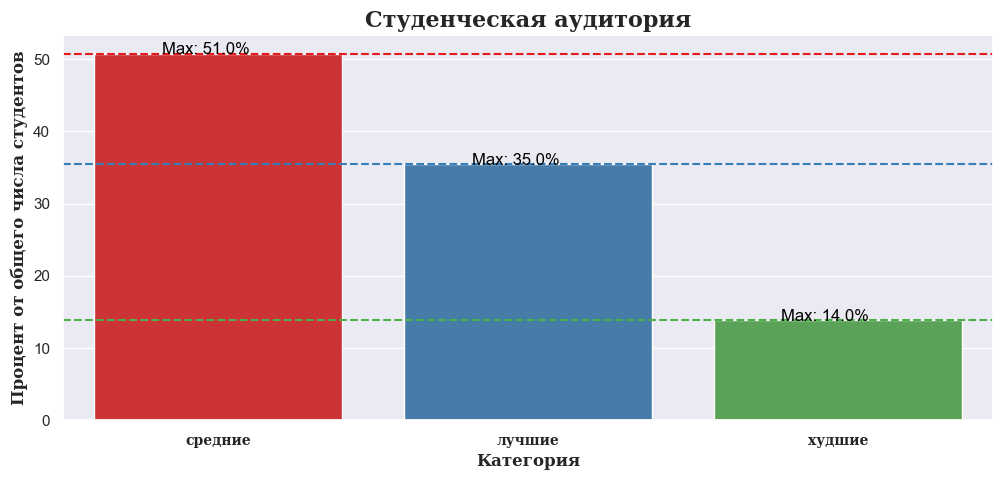

In [89]:
sudent_auditoriya.columns = ['category', 'percentage']

sns.set(font_scale=1)
custom_palette = sns.color_palette("Set1", n_colors=len(sudent_auditoriya))
plt.figure(figsize=(12, 5))
ax = sns.barplot(x='category', y='percentage', data=sudent_auditoriya, palette=custom_palette)

ax.set_xticklabels(['средние', 'лучшие', 'худшие'], fontdict={'fontsize': 10, 'fontweight': 'bold', 'fontfamily': 'serif'})

ax.set_ylabel('Процент от общего числа студентов', fontdict={'fontsize': 12, 'fontweight': 'bold', 'fontfamily': 'serif'})
ax.set_xlabel('Категория', fontdict={'fontsize': 12, 'fontweight': 'bold', 'fontfamily': 'serif'})
ax.set_title('Студенческая аудитория', fontdict={'fontsize': 16, 'fontweight': 'bold', 'fontfamily': 'serif'})

for i, value in enumerate(sudent_auditoriya['percentage']):
    ax.axhline(y=value, color=custom_palette[i], linestyle='--')
    ax.text(i + 0.1, value, f'Max: {round(value,0)}%', color='black', ha='right')
#plt.savefig('Студенческая аудитория.jpeg')
plt.show()


#### Вывод: 
В нашем проекте мы рассмотрели только ту категорию студентов, которая сдает экзамены. У нас получилось что, большинство студентов относятся к средней категории. Их 50 процентов от общего числа. Лучших студентов тоже немало, 35 процентов, и худших всего 13 процентов, что довольно мало. Также к числу худших относятся и те кто снялся с регистрации. Из этого следует, что у продакт-менеджера Василия довольно сильная аудитория студентов.
Необходимо выяснить почему только по курсам CCC и DDD сдают экзамены студенты. Возможно какая-то ошибка.